In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath
%matplotlib inline
from starkhelium import *
from tqdm import trange, tqdm
import os

from scipy.constants import h, hbar, c, alpha, m_e, e, epsilon_0, atomic_mass, pi, physical_constants
a_0 = physical_constants['Bohr radius'][0]
En_h = alpha**2.0 * m_e * c**2.0;
scl = c*10**-9 * En_h /(h * c);

# Calculate Stark map and Stark interactions terms

In [2]:
# Calculate everything needed to plot the Stark map. Use Eigenvectors to compute state-mixing weights
# quantum numbers
nmin = 4
nmax = 6
S = 1
field_orientation = 'parallel'
m_vals = np.array([0,1,2])
n_vals, L_vals, J_vals, neff, En, H_0, mat_S = [], [], [], [], [], [], []

for m_val in m_vals:
    n_vals_tmp, L_vals_tmp = get_nl_vals(nmin, nmax, m_val)
    J_vals_tmp = get_J_vals(S, L_vals_tmp, diff=1)
    # quantum defects
    neff_tmp = n_vals_tmp - get_qd(S, n_vals_tmp, L_vals_tmp, J_vals_tmp)
    # energy levels
    En_tmp = W_n(S, n_vals_tmp, L_vals_tmp, J_vals_tmp)
    # field-free Hamiltonian
    H_0_tmp = np.diag(En_tmp)
    # find the off-diagonal terms of the Stark interaction matrix
    mat_S_tmp = stark_matrix_select_m(n_vals_tmp, neff_tmp, L_vals_tmp, m_val, field_orientation, dm_allow=[0])
    
    # Save each m variable into arrays
    n_vals.append(n_vals_tmp)
    L_vals.append(L_vals_tmp)
    J_vals.append(J_vals_tmp) 
    neff.append(neff_tmp) 
    En.append(En_tmp) 
    H_0.append(H_0_tmp)
    mat_S.append(mat_S_tmp)

calculate Stark terms: 100%|████████████████████| 9/9 [00:00<00:00, 999.94it/s]


In [3]:
# Calculate Stark interaction terms using all m-manifolds. Used for computing TDM
# quantum numbers
n_vals_all_m, L_vals_all_m, m_vals_all_m = get_nlm_vals(nmin, nmax)
J_vals_all_m = get_J_vals(S, L_vals_all_m, 1)
# quantum defects
neff_all_m = n_vals_all_m - get_qd(S, n_vals_all_m, L_vals_all_m, J_vals_all_m)
# find the off-diagonal terms of the Stark interaction matrix
mat_S_all_m = stark_matrix(n_vals_all_m, neff_all_m, L_vals_all_m, m_vals_all_m, 
                           field_orientation=field_orientation, dm_allow=[0,-1,+1])

Calculating Stark terms: 100%|████████████████| 77/77 [00:00<00:00, 744.66it/s]


In [4]:
# specify the electric field
field = np.linspace(0.00, 2*10**6, 501) # V /cm
field_au = field * 100 / (En_h_He/(e*a_0_He))
# specify the magnetic field (in Telsa)
B_z = 1.6154E-3
# (in atomic units)
B_z_au = B_z / (hbar/(e*a_0_He**2))

# diagonalise for each field
eig_vals, eig_vecs = [], []
for m_idx, m_val in enumerate(m_vals):
    # Zeeman interaction Hamiltonian
    H_Z = np.diag(E_zeeman(np.ones_like(n_vals[m_idx])*m_val, B_z_au))
    eig_vals_tmp, eig_vecs_tmp = stark_map(H_0[m_idx], mat_S[m_idx], field_au, H_Z=H_Z, returnEigVecs=True)
    eig_vals.append(eig_vals_tmp)
    eig_vecs.append(eig_vecs_tmp)

diagonalise Hamiltonian: 100%|████████████| 501/501 [00:00<00:00, 10100.39it/s]


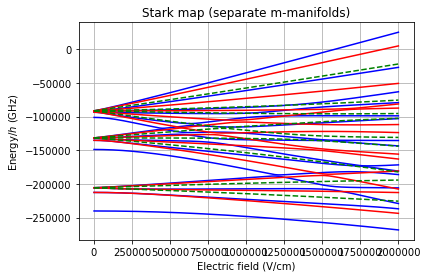

In [205]:
plt.plot(field, eig_vals[0]*scl, 'b', label='m=0')
plt.plot(field, eig_vals[1]*scl, 'r', label='m=1')
plt.plot(field, eig_vals[2]*scl, '--g', label='m=2')
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Energy/$h$ (GHz)')
plt.title('Stark map (separate m-manifolds)')
plt.grid()

# Transition dipole moment between two states

From state:	 n = 5 , l = 0 , m = 0
To state:	 n = 4 , l = 3 , m = 0


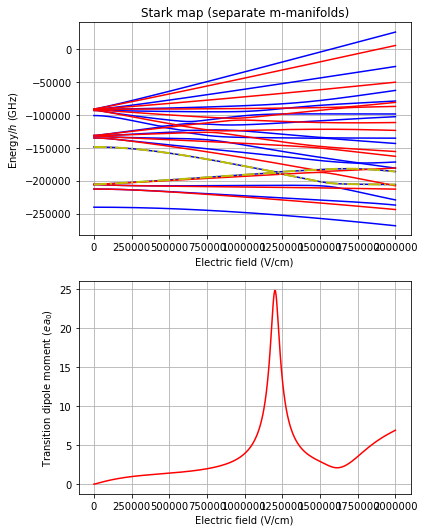

In [206]:
state_i = 4
state_f = 3
m_i = 0
m_f = 0

idx_m_i = np.where(m_vals==m_i)[0][0]
idx_m_f = np.where(m_vals==m_f)[0][0]
idx_m_i_all_m = np.where(m_vals_all_m==m_i)[0]
idx_m_f_all_m = np.where(m_vals_all_m==m_f)[0]

tdm = []
for i, f in enumerate(field):
    weights = ( np.outer( eig_vecs[idx_m_i][i,:,state_i], eig_vecs[idx_m_f][i,:,state_f] ) )
    tdm.append( np.abs( np.sum( weights * mat_S_all_m[idx_m_i_all_m,:][:,idx_m_f_all_m] ) ) )
    
plt.figure(figsize=(6,7.5))
plt.subplot(2, 1, 1)
plt.plot(field, eig_vals[0]*scl, 'b', label='m=0')
plt.plot(field, eig_vals[1]*scl, 'r', label='m=1')
plt.plot(field, eig_vals[idx_m_i][:,state_i]*scl, '-.y', lw=2)
plt.plot(field, eig_vals[idx_m_f][:,state_f]*scl, '-.y', lw=2)
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Energy/$h$ (GHz)')
plt.title('Stark map (separate m-manifolds)')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(field, tdm, 'r', label='tdm')
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Transition dipole moment ($ea_0$)')
plt.grid()
plt.tight_layout()

print('From state:\t n =', n_vals[idx_m_i][state_i], ', l =', L_vals[idx_m_i][state_i], ', m =', m_vals[idx_m_i])
print('To state:\t n =', n_vals[idx_m_f][state_f], ', l =', L_vals[idx_m_f][state_f], ', m =', m_vals[idx_m_f])

# State-character of states

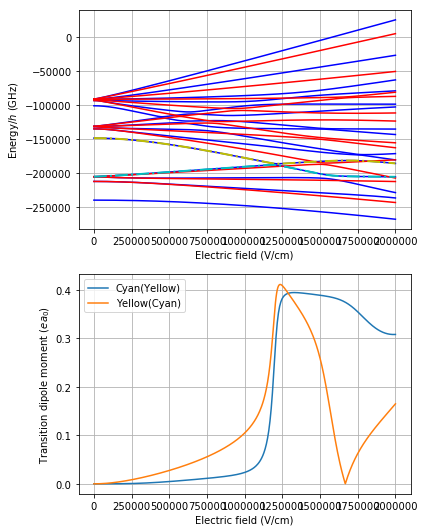

In [207]:
state_i = 4
state_f = 3
m_i = 0
m_f = 0

idx_m_i = np.where(m_vals==m_i)[0][0]
idx_m_f = np.where(m_vals==m_f)[0][0]
idx_m_i_all_m = np.where(m_vals_all_m==m_i)[0]
idx_m_f_all_m = np.where(m_vals_all_m==m_f)[0]

l_char = []
for i, f in enumerate(field):
    l_char.append( [np.abs( eig_vecs[idx_m_i][i,state_f,state_i] ), np.abs( eig_vecs[idx_m_i][i,state_i,state_f] )] )
    
plt.figure(figsize=(6,7.5))
plt.subplot(2, 1, 1)
plt.plot(field, eig_vals[0]*scl, 'b', label='m=0')
plt.plot(field, eig_vals[1]*scl, 'r', label='m=1')
plt.plot(field, eig_vals[idx_m_i][:,state_i]*scl, '-.y', lw=2)
plt.plot(field, eig_vals[idx_m_f][:,state_f]*scl, '-.c', lw=2)
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Energy/$h$ (GHz)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(field, np.array(l_char)[:,0], label='Cyan(Yellow)')
plt.plot(field, np.array(l_char)[:,1], label='Yellow(Cyan)')
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Transition dipole moment ($ea_0$)')
plt.grid()
plt.legend()
plt.tight_layout()

# Plot tdm shaded Stark map

In [208]:
def colorline(
    x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def create_XY_array(x, y):
    path = mpath.Path(np.column_stack([x, y]))
    verts = path.interpolated(steps=1).vertices
    return verts[:, 0], verts[:, 1]

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: divide by zero encountered in log


tdm max =  3.40641473682
From state:	 n = 6 , l = 0 , m = 0


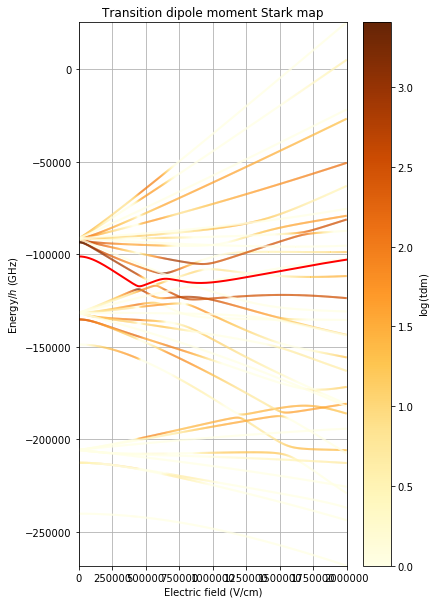

In [227]:
state_i = 9
m_i = 0

idx_m_i = np.where(m_vals==m_i)[0][0]
idx_m_i_all_m = np.where(m_vals_all_m==m_i)[0]

plt.figure(figsize=(6,10))
ax = plt.gca()
max_z = 0

for m_val_idx, m_val in enumerate(m_vals):
    for state_f in range(len(eig_vals[m_val_idx][0])):
        if not((m_val == m_i) and (state_i == state_f)):
            tdm = []
            idx_m_f = np.where(m_vals==m_val)[0][0]
            idx_m_f_all_m = np.where(m_vals_all_m==m_val)[0]
            for i, f in enumerate(field):
                weights = ( np.outer( eig_vecs[idx_m_i][i,:,state_i], eig_vecs[idx_m_f][i,:,state_f] ) )
                tdm.append( np.abs( np.sum( weights * mat_S_all_m[idx_m_i_all_m,:][:,idx_m_f_all_m] ) ) )
            x, y = create_XY_array(field, eig_vals[idx_m_f][:,state_f]*scl)
            z = np.log(tdm)
            max_z = np.max([max_z, np.max(z)])
            ax.add_collection( colorline(x, y, z, cmap=plt.get_cmap('YlOrBr'), linewidth=2, norm=plt.Normalize(0.0, 3.40)) )

plt.plot(field, eig_vals[idx_m_i][:,state_i]*scl, 'r', lw=2)
        
plt.xlim([np.min(field),np.max(field)])
plt.ylim([np.min(eig_vals[:1])*scl,np.max(eig_vals[:1])*scl])
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Energy/$h$ (GHz)')
plt.title('Transition dipole moment Stark map')
plt.grid()

fig = plt.gcf()
z = np.linspace(0,max_z,len(field))
lc = colorline(x, y, z, cmap=plt.get_cmap('YlOrBr'), linewidth=2, norm=None) 
axcb = fig.colorbar(lc)
axcb.set_label('$\log$(tdm)')
ax.collections[0]
        
print('tdm max = ', max_z)
print('From state:\t n =', n_vals[idx_m_i][state_i], ', l =', L_vals[idx_m_i][state_i], ', m =', m_vals[idx_m_i])